# Cognition and Computation Project - Giorgia Barzan 2089384, 21/02/2023


In this project, I will implement a DBN using the PyTorch library, and train it on the EMNIST dataset. I will then investigate some of its characteristics and evaluate its performance, with and without the presence of external noise and adversarial attacks.

I'm first downloading some scripts from a GitHub repository that implement a DBN in PyTorch.

In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
import copy
from DBN import DBN

I'm then choosing dynamically the kind of device used for computations (CPU or GPU).

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


I now download the EMNIST letters dataset, both the training and the test set. The EMNIST letters dataset is a set of 145600 handwritten character digits, 124800 for the training set and 20800 for the test set, in 26 balanced classes. Each image is in a format of 28x28 pixels.
Each pixel value has a range between 0 to 255 and in order to normalize them, by bringing the range between 0 and 1, each pixel needs to be devided by 255.

In [ ]:
%%capture
emnist_train = tv.datasets.EMNIST(root='./emnist_data/', split = 'letters', train=True, download=True,
                                         transform=tv.transforms.Compose([
                                                  tv.transforms.ToTensor()] 
                                         ))

emnist_test = tv.datasets.EMNIST(root='./emnist_data/', split = 'letters',
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))

In [ ]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

To verify that the data downloaded is right, I'll show one example:

The letter shown is the letter: v


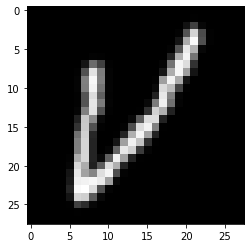

In [ ]:
idx = 80
img = emnist_train.data[idx].T
print("The letter shown is the letter: {}".format(emnist_train.classes[emnist_train.targets[idx]]) )
plt.imshow(img , cmap = 'gray')
plt.show()

As it can be seen in the code below, there are 27 targets, the first one (0) is associated to the value 'N/A' and the others are associated to the 26 letters of the alphabet. It can be easily noticed that there's no object in the training set with target 0, and since the presence of 'N/A's could be a problem in further operations, its target can be erased by simply removing '1' from both the training and test targets. I then transform the classes removing the 'N/A's.

In [ ]:
emnist_train.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [ ]:
torch.sum(emnist_train.targets==0)

tensor(0)

In [ ]:
classes=emnist_train.classes[1:]
train_targets=copy.deepcopy(emnist_train.targets)-1
test_targets=copy.deepcopy(emnist_test.targets)-1

I'm now loading the training and test data and their targets to the memory previously chosen.

In [ ]:
emnist_train.data = emnist_train.data.to(device)
emnist_test.data = emnist_test.data.to(device)

In [ ]:
train_targets = train_targets.to(device)
test_targets = test_targets.to(device)

#DBN Training
I'm now defining a Deep Belief Network, which is made by a stack of Restricted Boltzmann Machines. These energy-based models have the purpose of capturing the underlying structure of the training data by finding the probability distribution that generated it. This DBN is a hierarchical generative model with 3 hidden layers that will learn increasingly more complex features of the training data. After trying different configurations of the architechture and hyperparameters, I have chosen the ones that provide higher accuracies and avoid 'dead' receptive fields. The first hidden layer has 400 neurons, the second has 600 neurons and the third has 800 neurons. In order to have a faster convergence, I'm setting the learning rate to the moderate value of 0.11. The initial momentum is also set to a moderate value of 0.5, and it increases to the final value of 0.95, meaning that as the training progresses the optimization algorithm will place more emphasis on the previous update direction.


In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[400, 600, 800],
                k=1,
                learning_rate=0.11,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

The network can now be trained with 80 epochs and batch size equal to 150, meaning that the training algorithm will process the training data in batches of 150 samples for each epoch.

In [ ]:
num_epochs = 80
batch_size = 150

dbn_emnist.train_static(
    emnist_train.data,
    train_targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.5897     |0.0479       |340.5051   |5.4781     |
|20    |1.5265     |0.0458       |325.4498   |4.7567     |
|30    |1.5113     |0.0447       |321.7089   |4.8844     |
|40    |1.5051     |0.0441       |319.7541   |5.0313     |
|50    |1.5024     |0.0441       |319.2996   |5.1652     |
|60    |1.5005     |0.0441       |318.8048   |4.5038     |
|70    |1.4987     |0.0444       |318.1898   |5.0254     |
|80    |1.4972     |0.0427       |316.4960   |4.6062     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8964     |0.0468       |239.8119   |3.2620     |
|20    |1.8281     |0.0448       |235.7351   |2.8891     |
|30    |1.8144     |0.0423       |234.7017   |3.1440     |
|40    |1.8065     |0.0441       |234.1624   |3.3368     |
|50    |1.8058     |0.0428       |234.1895   |3.2991     |
|60    |1.8024     |0.0436       

## Visualizing receptive fields

Some of the learned weight can be visualized in a plot of the same size of the EMNIST images I used for training, where each square represents a receptive field of a neuron. This plot shows what parts of an image these neurons associated with these specific weight vectors are tuned to and with what strenght. In order to understand how the network encodes these images, I visualize some of the weights of each hidden layer, and it can be noticed how they are tuned to different parts of the images.

To avoid noise in the plots I apply a threshold on the learned weights. They could also have different ranges, so I scale them with `MinMaxScaler` from Scikit-Learn.

I'm defining these functions that get the weights of the hidden layer, that apply a threshold to the weights, that plot the weights of the receptive fields and that scale the weights.

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights  

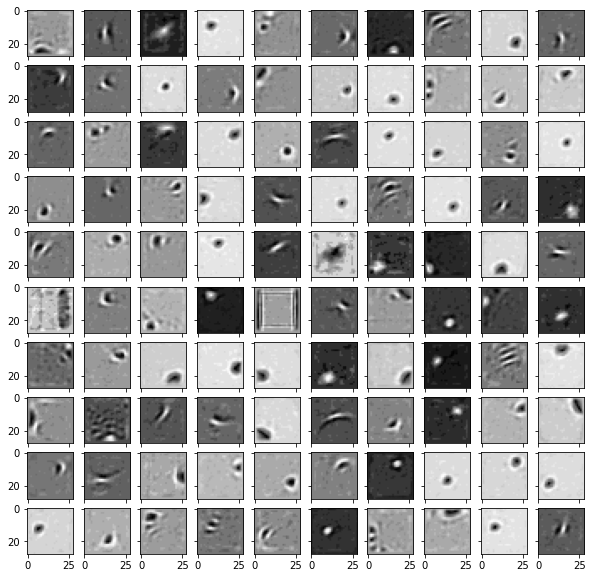

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

The weights in the second and third hidden layers don't have the same dimensionality as the EMNIST digits, therefore, I will need to project each of the vectors in a space of dimensionality `784` (`28`x`28`) in order to visualize them as images.

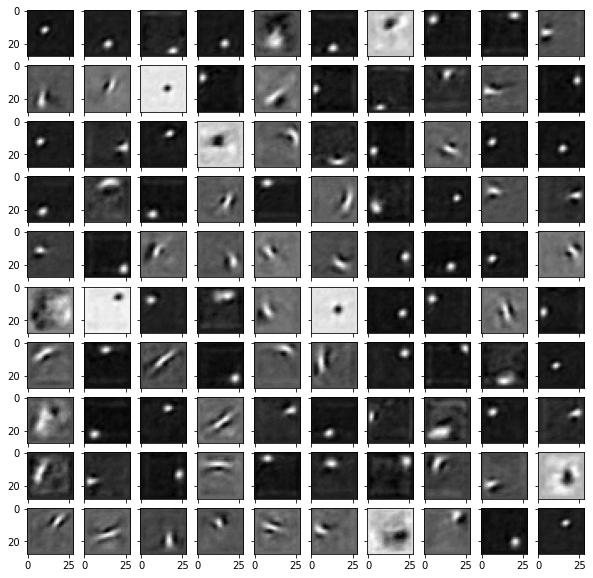

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

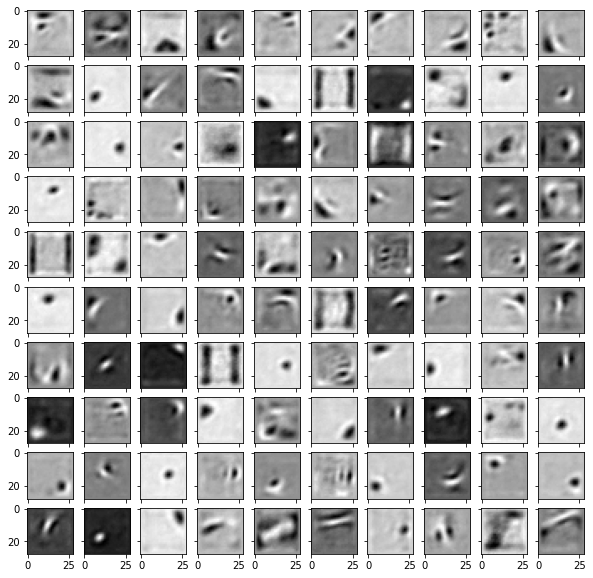

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_emnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)

## Clustering internal representations

With hierarchical clustering of internal representations we want to examine the structure in the intermediate activations of the network and improve the quality of the learned representations.
Before clustering, the centroid of the learned representations for each class needs to be computed, then the distances of each class to each centroid and the classes have to be assigned to the clusters, by using a standard hierarchical clustering algorithm.


Since this implementation of the `DBN` contains internally several `RBM` objects, I need to compute the hidden representation using the weights of each `RBM` contained in the `DBN`.

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

The representations computed using the second layer are computed using the ones from the first layer, and the representations computed using the third layer are computed using the ones from the second layer.

In [ ]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

I'm then computing the centroid of the representations of each class and I'm building a matrix containing all the centroids to comply with the input required by the clustering algorithm. I compute the matrices of each hidden representation.

In [ ]:
def get_mask(label):  # I use this function to filter by class
  labels = train_targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here I filter by class and compute the mean
    for label in range(26)
  }

def get_hidden_reprs_matrix(hidden_representation):  # I use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here I adjust the shape of centroids to do the concat
    for label in range(26)])

In [ ]:
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

I can finally define the dendogram plot function, which visualizes the clustering algorithm. I then plot the dendogram of each hidden representation matrix. It can be noticed from these dendograms how each hidden layer groups different letters in clusters, sometimes in a similar way and sometimes in a different way.

In [ ]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

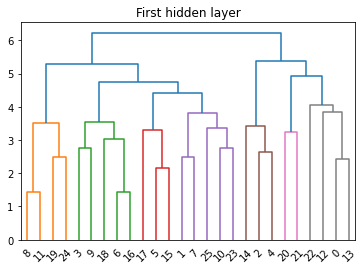

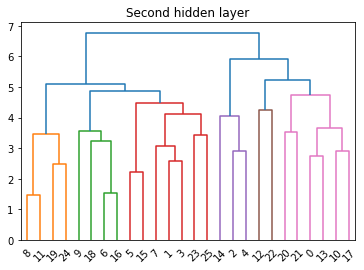

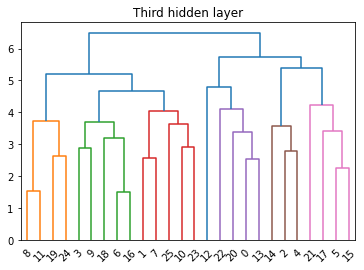

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")
plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

## Linear read-out

The purpose of linear read-out is combining the learned representations from the hidden layers to make a prediction. It therefore consists in classifying the input images with a simple linear classifier, by using the learned representations. 

The class for the linear model needs to be first defined :

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 26)

  def forward(self, x):
    return self.linear(x)

I'm then computing a linear model for each layer of the DBN:

In [ ]:
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

I now train the linear classifiers on the hidden representations from each layer using the actual labels of the EMNIST letters dataset as targets. After trying different values, I have decided to set the epochs value to 4000 and the learning rate to 0.2 in order to decrease the loss and reach an accuracy of more than 80% during prediction:

In [ ]:
def train_linear(linear, hidden_reprs):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.2)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 4000

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = train_targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [ ]:
train_linear(linear1, hidden_repr_layer_1)

epoch :   1/4000, loss = 3.3115
epoch : 101/4000, loss = 1.3718
epoch : 201/4000, loss = 1.1233
epoch : 301/4000, loss = 1.0120
epoch : 401/4000, loss = 0.9425
epoch : 501/4000, loss = 0.8929
epoch : 601/4000, loss = 0.8546
epoch : 701/4000, loss = 0.8237
epoch : 801/4000, loss = 0.7979
epoch : 901/4000, loss = 0.7758
epoch : 1001/4000, loss = 0.7567
epoch : 1101/4000, loss = 0.7397
epoch : 1201/4000, loss = 0.7246
epoch : 1301/4000, loss = 0.7110
epoch : 1401/4000, loss = 0.6986
epoch : 1501/4000, loss = 0.6873
epoch : 1601/4000, loss = 0.6768
epoch : 1701/4000, loss = 0.6672
epoch : 1801/4000, loss = 0.6582
epoch : 1901/4000, loss = 0.6499
epoch : 2001/4000, loss = 0.6421
epoch : 2101/4000, loss = 0.6347
epoch : 2201/4000, loss = 0.6278
epoch : 2301/4000, loss = 0.6213
epoch : 2401/4000, loss = 0.6151
epoch : 2501/4000, loss = 0.6093
epoch : 2601/4000, loss = 0.6037
epoch : 2701/4000, loss = 0.5984
epoch : 2801/4000, loss = 0.5933
epoch : 2901/4000, loss = 0.5885
epoch : 3001/4000, l

In [ ]:
train_linear(linear2, hidden_repr_layer_2)

epoch :   1/4000, loss = 3.2995
epoch : 101/4000, loss = 1.3462
epoch : 201/4000, loss = 1.1176
epoch : 301/4000, loss = 1.0117
epoch : 401/4000, loss = 0.9444
epoch : 501/4000, loss = 0.8956
epoch : 601/4000, loss = 0.8577
epoch : 701/4000, loss = 0.8267
epoch : 801/4000, loss = 0.8007
epoch : 901/4000, loss = 0.7783
epoch : 1001/4000, loss = 0.7586
epoch : 1101/4000, loss = 0.7411
epoch : 1201/4000, loss = 0.7254
epoch : 1301/4000, loss = 0.7112
epoch : 1401/4000, loss = 0.6982
epoch : 1501/4000, loss = 0.6862
epoch : 1601/4000, loss = 0.6751
epoch : 1701/4000, loss = 0.6648
epoch : 1801/4000, loss = 0.6552
epoch : 1901/4000, loss = 0.6462
epoch : 2001/4000, loss = 0.6378
epoch : 2101/4000, loss = 0.6298
epoch : 2201/4000, loss = 0.6223
epoch : 2301/4000, loss = 0.6151
epoch : 2401/4000, loss = 0.6084
epoch : 2501/4000, loss = 0.6019
epoch : 2601/4000, loss = 0.5958
epoch : 2701/4000, loss = 0.5899
epoch : 2801/4000, loss = 0.5843
epoch : 2901/4000, loss = 0.5789
epoch : 3001/4000, l

In [ ]:
train_linear(linear3, hidden_repr_layer_3)

epoch :   1/4000, loss = 3.2731
epoch : 101/4000, loss = 1.2900
epoch : 201/4000, loss = 1.0479
epoch : 301/4000, loss = 0.9372
epoch : 401/4000, loss = 0.8676
epoch : 501/4000, loss = 0.8177
epoch : 601/4000, loss = 0.7793
epoch : 701/4000, loss = 0.7483
epoch : 801/4000, loss = 0.7225
epoch : 901/4000, loss = 0.7005
epoch : 1001/4000, loss = 0.6813
epoch : 1101/4000, loss = 0.6645
epoch : 1201/4000, loss = 0.6494
epoch : 1301/4000, loss = 0.6359
epoch : 1401/4000, loss = 0.6236
epoch : 1501/4000, loss = 0.6124
epoch : 1601/4000, loss = 0.6020
epoch : 1701/4000, loss = 0.5925
epoch : 1801/4000, loss = 0.5836
epoch : 1901/4000, loss = 0.5754
epoch : 2001/4000, loss = 0.5677
epoch : 2101/4000, loss = 0.5604
epoch : 2201/4000, loss = 0.5536
epoch : 2301/4000, loss = 0.5472
epoch : 2401/4000, loss = 0.5411
epoch : 2501/4000, loss = 0.5353
epoch : 2601/4000, loss = 0.5298
epoch : 2701/4000, loss = 0.5246
epoch : 2801/4000, loss = 0.5196
epoch : 2901/4000, loss = 0.5149
epoch : 3001/4000, l

The representation for the test can now be built and be used to evaluate the trained linear readouts:

In [ ]:
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

The predictions can now be computed:

In [ ]:
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

Finally, I can compute the accuracy scores between the predictions and the actual values. It can be noticed how the value of the accuracy increases in the second hidden layer and more in the third hidden layer. There is therefore an improvement in classification performance as we move towards the deepest layers of the network, meaning that the features are disentangled.

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
acc1=compute_accuracy(predictions_test1, test_targets)
acc2=compute_accuracy(predictions_test2, test_targets)
acc3=compute_accuracy(predictions_test3, test_targets)
print("Accuracy of H1: %.3f" % acc1)
print("Accuracy of H2: %.3f" % acc2)
print("Accuracy of H3: %.3f" % acc3)

Accuracy of H1: 0.842
Accuracy of H2: 0.847
Accuracy of H3: 0.861


The accuracies can now be visualized with the confusion matrix. This matrix shows in the diagonal the right predictions, and in the rest of the matrix the wrong ones. The square of a letter will be more evident if it gets predicted wrong more often than other letters. 

These matrices look very similar because the accuracies of the hidden layers are close to each others or because there are similarities in the learned representations at each hidden layer.

Some things can be understood from these matrices, for example that the letter 'i' has been sometimes classified as the letter 'l' and viceversa, and the letter 'q' has been ocasionally classified as the letter 'g'. These errors are quite understandable since these letters are similar and therefore could be commonly mistaken. 

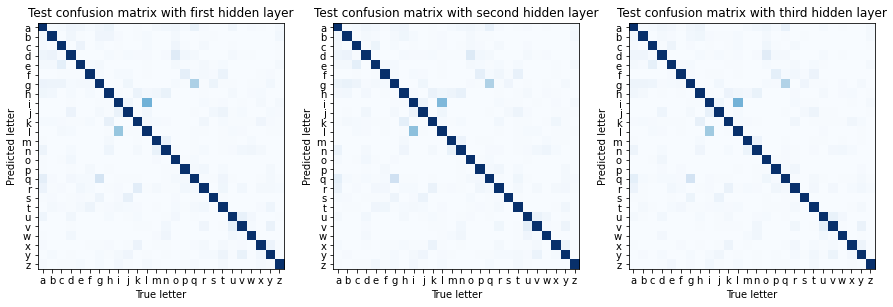

In [ ]:
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(1,3, figsize=(15, 5))

cm1=confusion_matrix(test_targets.cpu(), torch.argmax(predictions_test1.cpu(), axis=1), normalize='true')
axs[0].imshow(cm1,'Blues',vmax=0.5)
axs[0].set_xticks(range(26))
axs[0].set_xticklabels(labels=classes)
axs[0].set_yticks(range(26))
axs[0].set_yticklabels(labels=classes)
axs[0].set_title('Test confusion matrix with first hidden layer')
axs[0].set_xlabel('True letter')
axs[0].set_ylabel('Predicted letter')

cm2=confusion_matrix(test_targets.cpu(), torch.argmax(predictions_test2.cpu(), axis=1), normalize='true')
axs[1].imshow(cm2,'Blues',vmax=0.5)
axs[1].set_xticks(range(26))
axs[1].set_xticklabels(labels=classes)
axs[1].set_yticks(range(26))
axs[1].set_yticklabels(labels=classes)
axs[1].set_title('Test confusion matrix with second hidden layer')
axs[1].set_xlabel('True letter')
axs[1].set_ylabel('Predicted letter')

cm3=confusion_matrix(test_targets.cpu(), torch.argmax(predictions_test3.cpu(), axis=1), normalize='true')
axs[2].imshow(cm3,'Blues',vmax=0.5)
axs[2].set_xticks(range(26))
axs[2].set_xticklabels(labels=classes)
axs[2].set_yticks(range(26))
axs[2].set_yticklabels(labels=classes)
axs[2].set_title('Test confusion matrix with third hidden layer')
axs[2].set_xlabel('True letter')
axs[2].set_ylabel('Predicted letter')

plt.show()


## Robustness to noise

The robustness of the representations learned by the DBN can be evaluated in the presence of perturbations in the sensory signal, by injecting some noise in the input images. This evaluation is important because it helps to identify potential weaknesses in the network, that could then be improved by modifying the architecture or adding regularization. 


In [ ]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
  return emnist_data + random_gaussian_tensor

This is what a noisy image looks like:

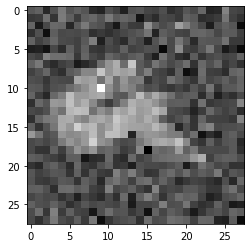

In [ ]:
noise_level = 0.3
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)
__ = plt.imshow(emnist_test_with_noise[0].T.reshape(28, 28).to("cpu"), cmap="gray")

I now define a function that returns the accuracy values of each hidden layer given a noise level. In this function I compute the hidden representations for the noisy images using the DBN, then I use the read-out classifiers that I trained on the representations without noise to classify the noisy stimuli and compute the accuracy. These accuracies improve at each hidden layer.

In [ ]:
def get_accuracy_values_at_noise_level(noise_level):

  emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)  # first, let's create noisy test images
  
  hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)
 
  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, test_targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, test_targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, test_targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden

In [ ]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])

Accuracy of H1 read-out: 0.760
Accuracy of H2 read-out: 0.826
Accuracy of H3 read-out: 0.846


The psychometric curves for the DBN at different noise levels can finally be created and visualized, and it can be noticed a high gap between the performance of the first hidden layer and the other layers and, generally, that the higher the hidden layer, the better the performance.

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden"])

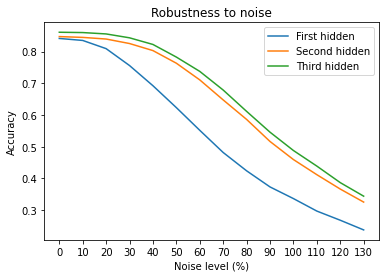

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

## Perturbing the models with adversarial attacks

### Fast gradient sign method

I'm now perturbating the model with adversarial attacks. This is done by modifying the input so that the model cannot correctly classify it anymore. If the model cannot classify the input, it means that the loss has to increase.

During the training phase of the model, in the gradient descent, we modify its weights by computing the gradient of the loss function, which is presented as a function of the input, the model's parameters and the outputs ($J(w, x, y)$). More precisely, the model's weights are updated using the opposite direction with respect to the gradient, because we want it to decrease. Since the goal of perturbating with adversarial attacks is to increase the loss function, we have to act in the opposite way of the gradient descent. This can be done by modifying the input instead of the model's weights and by going in the *same* direction with respect to the gradient.

The adversarial sample will then look like:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

In [ ]:
import torch.nn.functional as functional
from tqdm.notebook import tqdm

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

### Adversarial samples

I'm defining a new class of DBN with read out included, in order to have adversarial samples. 

The DBN with read out model is then defined by the previous DBN with the three hidden layers, specifying the level for the target of the read out, and also for the attack, which is the last hidden layer.

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_emnist = dbn_emnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_emnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
      to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_emnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [ ]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3], readout_level=2)

An adversiarial sample looks like this: 

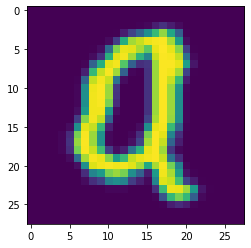

In [ ]:
test_sample_idx = 19
test_image = emnist_test.data[test_sample_idx].T.reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

This "clean" image can be classified using the model previously trained and then be modified to attack the network.

In [ ]:
attacked_model = dbn_with_readout

In [ ]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {classes[prediction]}.")

The prediction of the model for this clean sample is a.


I now create, visualize and predict the corresponding adversarial sample. Although we can still recognize the letter, it's clearly present some distorsion in the image that may cause problems to the model in terms of correct classification. In this specific case, if the model classified the sample correctly, it wouldn't have been an indication of a general good response to adversarial attacks, which will be measured later. 


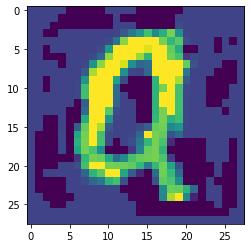

In [ ]:
epsilon = 0.2  # define strenght of the attack
test_image_label = test_targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [ ]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {classes[torch.argmax(model_outputs)]}.")

The prediction of the model for the perturbed sample is u.


### Resisting to adversarial attacks

I can now evaluate the ability to resist to adversarial attacks of the DBN model.

I will also test the ability of the DBN to reduce the impact of the attack by performing one "top-down" reconstruction step, from the hidden representation of the last layer to the visible units, and back to the hidden representation. The "top-down" processing consists in using the activations of the higher-level hidden layer, which capture more abstract features of the data, to guide the processing of lower-level features in a top-down matter.

In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        target=target-1 #'-1' because there needs to be 26 targets
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack
        
        output = model.forward(data)

        init_pred = torch.argmax(output)
        
        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28).T)
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28).T)
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28).T)
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST(root='./emnist_data/', split = 'letters', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=5200, shuffle=True)

In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=0)

  0%|          | 0/4 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 60.68%



I finally test whether using one step of top-down reconstruction from the generative model allows to improve resilience to attacks, and see that in this case it does:

  0%|          | 0/4 [00:00<?, ?it/s]


Here's the original sample:



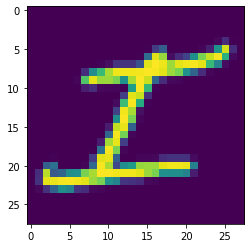


Here's a perturbed sample:



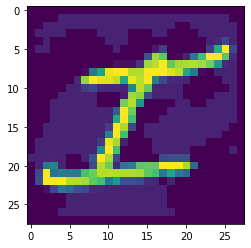


Here's what a 1-steps reconstructed sample looks like:



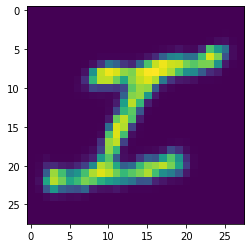


Epsilon: 0.1
Test Accuracy: 69.07%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

### Effect of the noise parameter $\epsilon$

I can now compare the robustness of each model (with and without top-down) to different levels of adversarial attacks, and visualize it with psychometric curves. 

From the graph it can be noticed how the model without top-down outperforms the one with top-down with a low strength of adversarial attacks, while when this increases so does the performance of the DBN with top-down with respect to the one without top-down. Generally, when the epsilon value increases, the performance of both the DBN models decrease. 

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

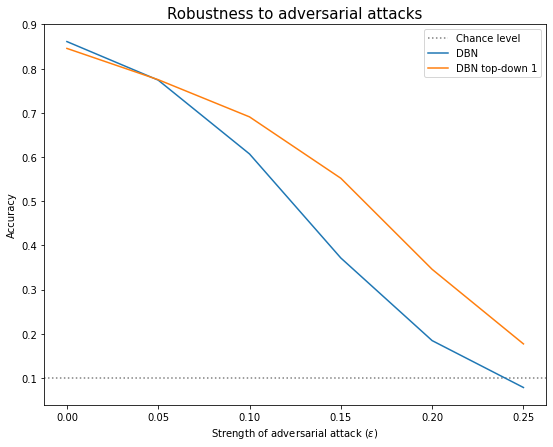

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level","DBN", "DBN top-down 1"])

# Conclusions

The DBN trained in the EMNIST letter dataset is discreetly capable of accurately classifying handwritten letters, making human-like mistakes. However, when the images are subjected to noise or adversarial attacks, the model's performance decreases significantly. One possible solution to this problem could be using a more robust model.